# Numerical Exercise 07

## Assigment
### Exercise 07.1
In the NSL simulator code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Exercise 07.2
Use the NSL simulator code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$. What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Exercise 07.3
Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the NSL simulator code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Exercise 07.4

By means of your upgraded NSL simulator code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ...  and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

---

## Resolution

### Tail corrections
The tail corrections for the potential energy and pressure are given by the following formulas:
$$
\frac{V_{\text{tail}}}{N} = \frac{8\pi\rho\epsilon}{9 r_c^9 } - \frac{8\pi\rho\epsilon}{3 r_c^3 }
$$
$$
\frac{P_{\text{tail}}}{\rho T} = 32\pi\rho^2\frac{\epsilon}{3}\left(\frac{1}{3r_c^9} - \frac{1}{r_c^3}\right)
$$

In the code these formulas translate to the following implementation:
```cpp
/* ... */
if( property == "POTENTIAL_ENERGY" ){
    /* other code... */
    #if defined(TAIL_CORRECTION)
        _vtail = 8.*M_PI*_rho*(1./(9.*pow(_r_cut, 9))-1./(3.*pow(_r_cut, 3)));
    #else
        _vtail = 0.;
    #endif
}
/* other code ... */
else if( property == "PRESSURE" ){
    /* other code ...*/
    #if  defined(TAIL_CORRECTION)
        _ptail = 32.*M_PI*_rho*(1./(9.*pow(_r_cut, 9))-1./(6.*pow(_r_cut, 3)));
    #else
        _ptail = 0.;
    #endif
}
/* ... */
```
and the tail corrections are added to the potential energy and pressure. They are only calculated if the `TAIL_CORRECTION` flag is defined, so old code which uses the same library will continue to work without the correction.

### Autocorrelation function
The autocorrelation function is calculated by the following formula:
$$
\chi(t) = \frac{\langle x(t_0)x(t_0+t)\rangle - \langle x(t_0)\rangle^2}{\langle x(t_0)^2\rangle - \langle x(t_0)\rangle^2}
$$
where $x(t)$ is the value of the observable at time $t$ and $\langle \cdot \rangle$ is the average over the whole simulation.

The autocorrelation function is useful  to investigate memory effects in the data. 
- If $\chi$ is positive, it means that the data is correlated. A value at time $t$ is influenced by the value at time $t_0$.
- If $\chi$ is equal to zero, it means that the data is uncorrelated, hence all the values in the series are independent.
- If $\chi$ is negative, it means that the data is anti-correlated. A value at time $t$ is influenced by the opposite value at time $t_0$.

In our data we are searching the time at which the autocorrelation function decays to zero. This time is called correlation time $\tau$. The block size should be larger than $\tau$ to avoid correlations between blocks.

We can also try to fit the autocorrelation function with an exponential function to estimate the correlation time.
$$
\chi(t) \propto \exp\left(-\frac{t}{\tau}\right)
$$

<!-- add implementations -->

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.optimize import curve_fit
import scipy.signal as signal
import statsmodels.api as sm
import math

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
names = ["solid", "liquid", "gas"]



Delta at acceptance 0.5 for solid: 0.05662551440329222
Delta at acceptance 0.5 for liquid: 0.11531250000000007
Delta at acceptance 0.5 for gas: 2.675000000000001


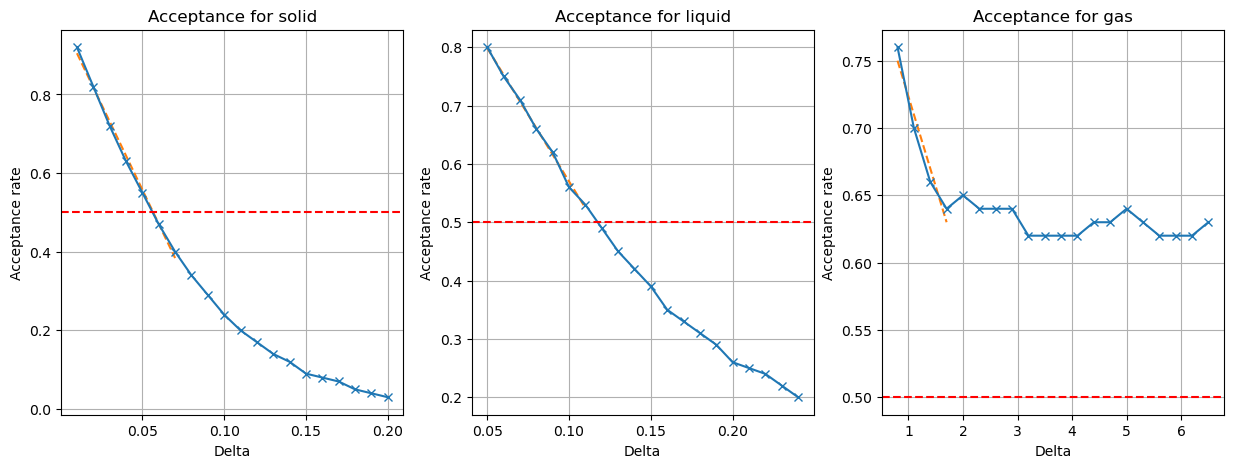

In [3]:
fig = plt.figure(figsize=(15,5))
for i in range(3):
    temp, delta, acceptance = np.loadtxt("../data/ex07_acceptance_{phase}.dat".format(phase=names[i]), unpack=True, usecols=(0,1,2), skiprows=1)
    fig.add_subplot(1,3,i+1)
    acceptance_subset = acceptance[:7]
    idx = np.abs(acceptance_subset - 0.5).argmin()
    #add linear fit for acceptance subset
    x = delta[:7]
    y = acceptance[:7]
    if(i == 2):
        x = delta[:4]
        y = acceptance[:4]
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    slope = results.params[1]
    intercept = results.params[0]
    fit = slope*x + intercept
    plt.plot(x, fit, color=colors[1], linestyle="--")
    # calculate delta at acceptance 0.5
    delta05 = (0.5 - intercept) / slope
    print("Delta at acceptance 0.5 for {phase}: {delta}".format(phase=names[i], delta=delta05))

    # delta_at_acc_05 = delta[idx]
    # print("Delta at acceptance 0.5 for {phase}: {delta}".format(phase=names[i], delta=delta_at_acc_05))
    plt.plot(delta, acceptance, marker="x")
    plt.title("Acceptance for {phase}".format(phase=names[i]))
    plt.xlabel("Delta")
    plt.ylabel("Acceptance rate")
    plt.grid(True)
    plt.axhline(y=0.5, color='r', linestyle='--')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


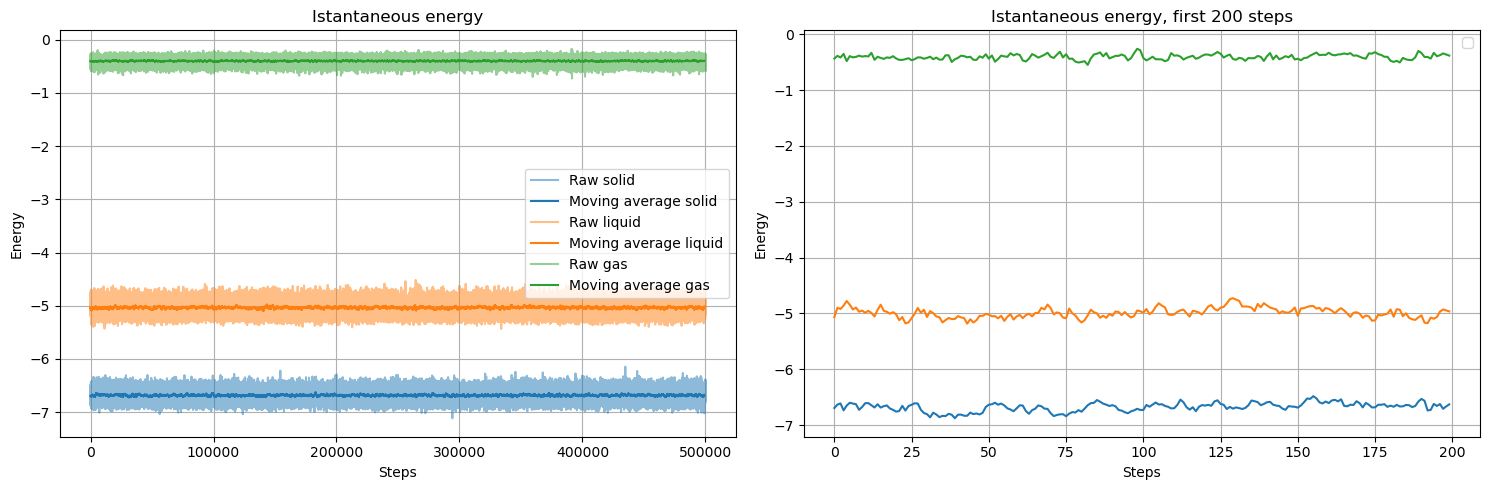

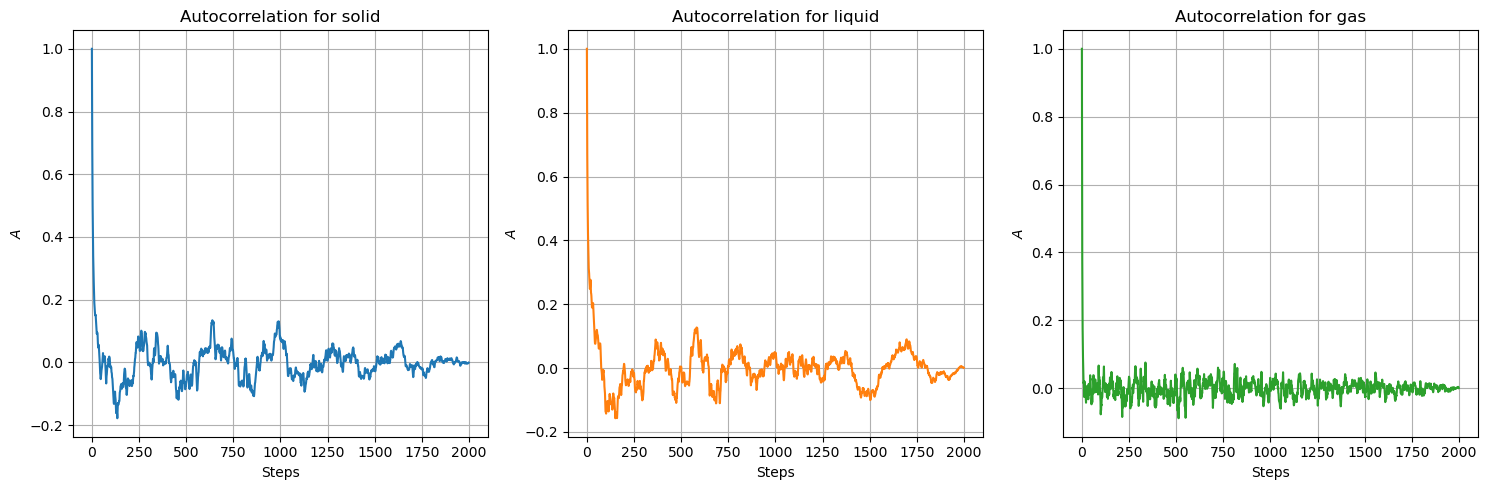

[array([ 1.00000000e+00,  8.19798307e-01,  6.88350340e-01, ...,
       -2.87305597e-03, -1.71508092e-03, -9.65007253e-04]), array([1.00000000e+00, 8.05684852e-01, 6.70105695e-01, ...,
       1.04391913e-03, 1.39232143e-03, 9.20372177e-04]), array([1.00000000e+00, 5.87876340e-01, 3.76371593e-01, ...,
       3.74759309e-03, 2.19513803e-03, 6.08574791e-04])]
tau solid: 7.57388548924093
tau liquid: 12.185024036187722
tau gas: 2.1418434318942126


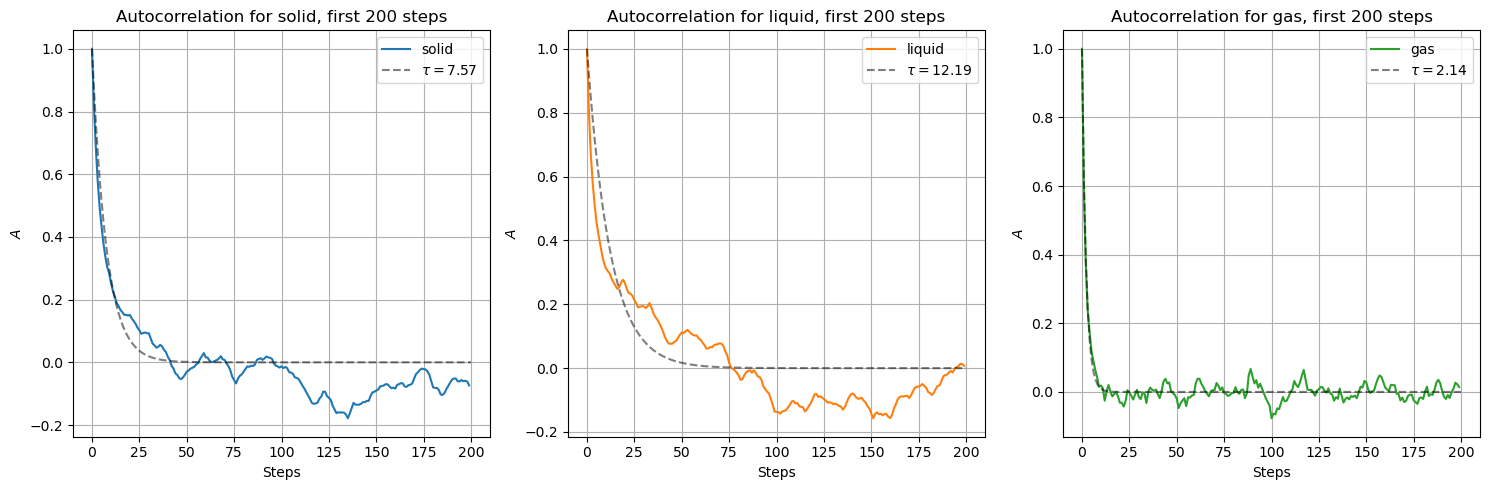

[7.57388548924093, 12.185024036187722, 2.1418434318942126]


In [14]:
# def calculate_autocorrelation(series):
#     n = len(series)
#     mean = np.mean(series)
#     centered_series = series - mean
#     autocorrelation = np.correlate(centered_series, centered_series, mode='full')[-n:]
#     autocorrelation /= autocorrelation[0]
#     return autocorrelation

def calculate_autocorrelation(series):
    n = len(series)
    acorr = sm.tsa.acf(series, nlags = n-1)
    return acorr

def exponential(x, a, b):
    return a * np.exp(-b * x)

solid = np.loadtxt("../data/ex07_istant_solid.dat", unpack=True, usecols=(0))
liquid = np.loadtxt("../data/ex07_istant_liquid.dat", unpack=True, usecols=(0))
gas = np.loadtxt("../data/ex07_istant_gas.dat", unpack=True, usecols=(0))

fig = plt.figure(figsize=(15,5))
# moving average
window = 1000
moving_average = []

for i, series in enumerate([solid, liquid, gas]):
    plt.subplot(1,2,1)
    moving_average.append(np.convolve(series, np.ones(window)/window, mode='valid'))
    plt.plot(series, color=colors[i], alpha=0.5, label="Raw {phase}".format(phase=names[i]))
    plt.plot(moving_average[i], color=colors[i], label="Moving average {phase}".format(phase=names[i]))
    plt.title("Istantaneous energy")
    plt.xlabel("Steps")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(series[:200], color=colors[i])
    plt.title("Istantaneous energy, first 200 steps")
    plt.xlabel("Steps")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(15,5))
autocorr = []
for i, series in enumerate([solid, liquid, gas]):
    fig.add_subplot(1,3,i+1)
    autocorr.append(calculate_autocorrelation(series[20000:22000]))
    plt.plot(autocorr[i], color=colors[i])
    plt.title("Autocorrelation for {phase}".format(phase=names[i]))
    plt.xlabel("Steps")
    plt.ylabel(r"$A$")
    plt.grid(True)
plt.tight_layout()
plt.show()

print(autocorr)
tau = []
fig = plt.figure(figsize=(15,5))
for i in range(3):
    fig.add_subplot(1,3,i+1)
    plt.plot(autocorr[i][:200], color=colors[i], label=names[i])
    x = np.arange(len(autocorr[i][:200]))
    popt, pcov = curve_fit(exponential, x, autocorr[i][:200], bounds = ([1, 0], [np.inf, np.inf]))
    a_fit, b_fit = popt
    tau.append( 1 / b_fit)
    print('tau {}: {}'.format(names[i], tau[i]))
    x_fit = np.linspace(0, len(autocorr[i][:200]), 200)
    y_fit = exponential(x_fit, a_fit, b_fit)
    plt.plot(x_fit, y_fit, label=r"$\tau = {tau:.2f}$".format(tau=tau[i]), linestyle='--', color='black', alpha=0.5)
    plt.title("Autocorrelation for {phase}, first 200 steps".format(phase=names[i]))
    plt.xlabel("Steps")
    plt.ylabel(r"$A$")
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()
print(tau)


7.57388548924093
12.185024036187722
2.1418434318942126


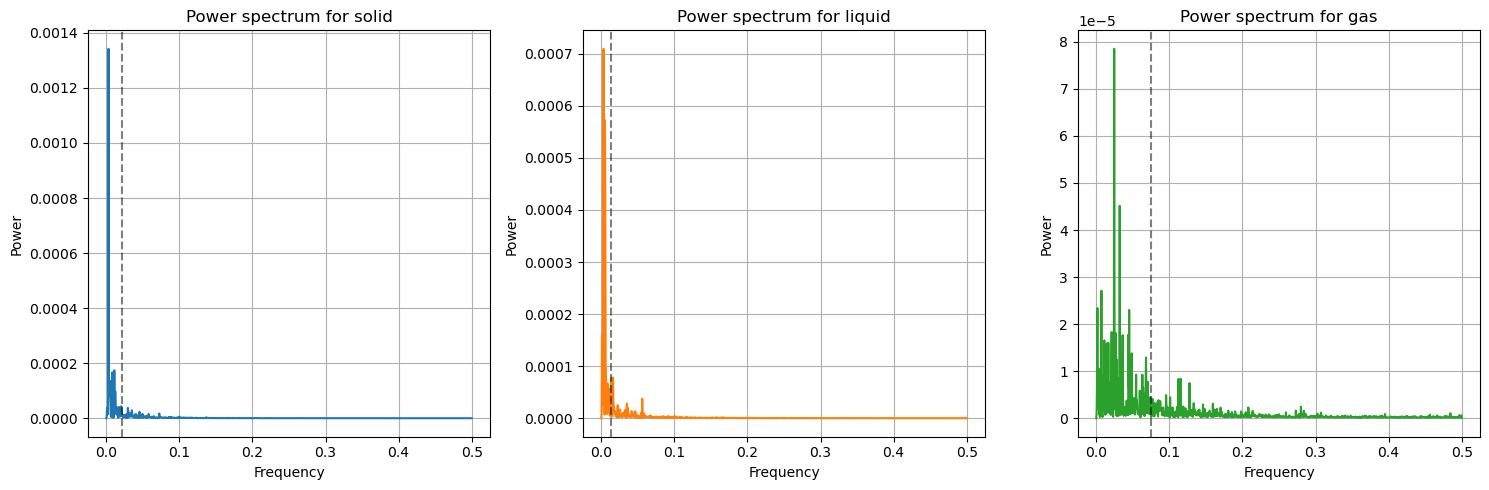

In [15]:
# power spectrum of the autocorrelation
fig = plt.figure(figsize=(15,5))
for i in range(3):
    fig.add_subplot(1,3,i+1)
    f, Pxx = signal.periodogram(autocorr[i], scaling='spectrum')
    plt.plot(f, Pxx, color=colors[i])
    # plt.xscale('log')
    # plt.yscale('log')
    print(tau[i])
    plt.axvline(x=1/(2*np.pi*tau[i]), color='black', linestyle='--', alpha=0.5)
    plt.title("Power spectrum for {phase}".format(phase=names[i]))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
istant_acc_solid = np.loadtxt("../data/ex07_istant_acc_solid.dat", unpack=True, usecols=(0))
istant_acc_liquid = np.loadtxt("../data/ex07_istant_acc_liquid.dat", unpack=True, usecols=(0))
istant_acc_gas = np.loadtxt("../data/ex07_istant_acc_gas.dat", unpack=True, usecols=(0))

mean_acc_solid = np.mean(istant_acc_solid)
mean_acc_liquid = np.mean(istant_acc_liquid)
mean_acc_gas = np.mean(istant_acc_gas)

std_acc_solid = np.std(istant_acc_solid)
std_acc_liquid = np.std(istant_acc_liquid)
std_acc_gas = np.std(istant_acc_gas)

print("Mean acceptance rate solid: {mean:.2f}".format(mean=mean_acc_solid))
print("Mean acceptance rate liquid: {mean:.2f}".format(mean=mean_acc_liquid))
print("Mean acceptance rate gas: {mean:.2f}".format(mean=mean_acc_gas))

Mean acceptance rate solid: 0.49
Mean acceptance rate liquid: 0.45
Mean acceptance rate gas: 0.63


Time scale: 1.12 LJ units
Time scale: 0.95 LJ units
Time scale: 0.91 LJ units


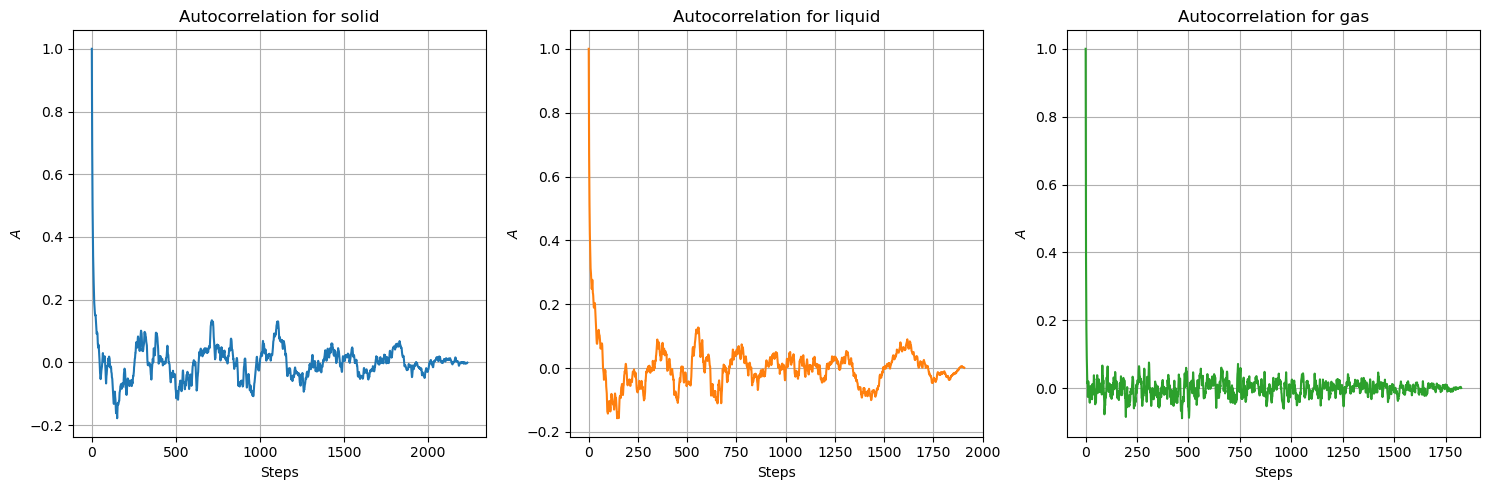

tau solid: 8.47209481670559
tau liquid: 11.623498602325531
tau gas: 1.9562046043659873


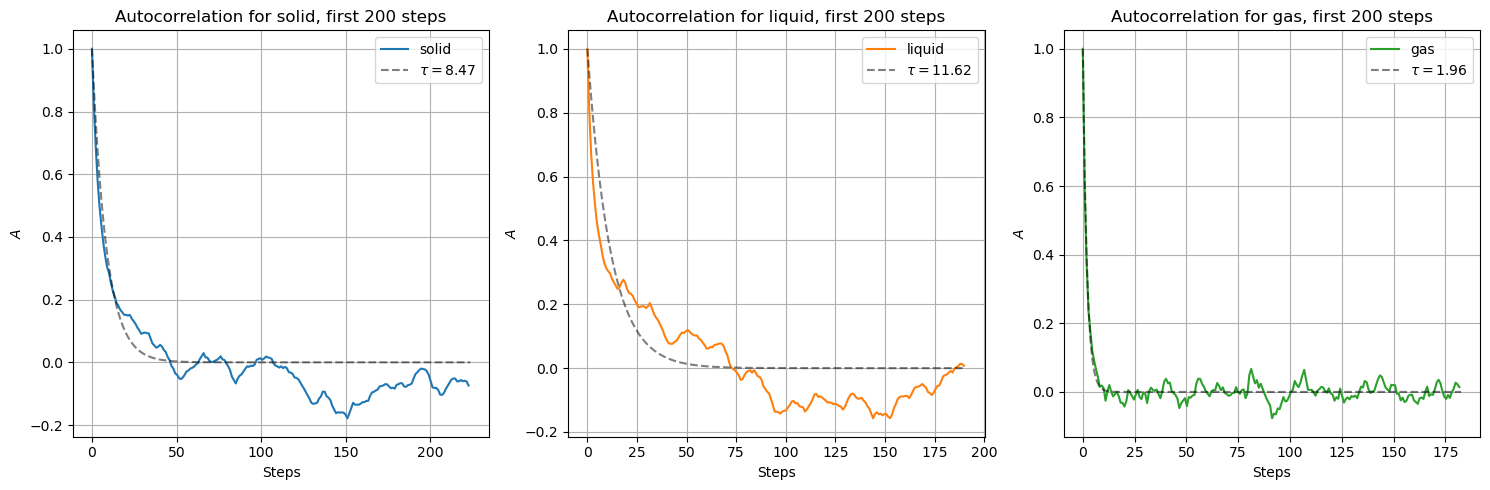

In [7]:
# $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu
def calculate_time_scale(temperature):
    # Lennard-Jones parameters
    sigma = 0.34  # nm
    epsilon = 120  # K
    m = 39.948  # amu
    # Convert Lennard-Jones units to SI units
    sigma_si = sigma * 1e-9  # m
    epsilon_si = epsilon * 1.380649e-23  # J
    m_si = m * 1.66053906660e-27  # kg
    # Calculate characteristic time scale
    tau = np.sqrt(m_si * sigma_si**2 / epsilon_si)
    # Convert to Lennard-Jones units
    tau_lj = tau * np.sqrt(epsilon_si / (m_si * sigma_si**2))
    # Calculate time scale in LJ units
    time_scale = tau_lj / np.sqrt(temperature)
    return time_scale

time_scale_08 = calculate_time_scale(0.8)
time_scale_11 = calculate_time_scale(1.1)
time_scale_12 = calculate_time_scale(1.2)
print("Time scale: {d:.2f} LJ units".format(d=time_scale_08))
print("Time scale: {d:.2f} LJ units".format(d=time_scale_11))
print("Time scale: {d:.2f} LJ units".format(d=time_scale_12))

timescale = [time_scale_08, time_scale_11, time_scale_12]



fig = plt.figure(figsize=(15,5))
for i, series in enumerate([solid, liquid, gas]):
    fig.add_subplot(1,3,i+1)
    xsteps = np.linspace(0, len(autocorr[i]), len(autocorr[i]))*timescale[i]
    plt.plot(xsteps, autocorr[i], color=colors[i])
    plt.title("Autocorrelation for {phase}".format(phase=names[i]))
    plt.xlabel("Steps")
    plt.ylabel(r"$A$")
    plt.grid(True)
plt.tight_layout()
plt.show()



fig = plt.figure(figsize=(15,5))
for i in range(3):
    fig.add_subplot(1,3,i+1)
    xsteps = np.linspace(0, len(autocorr[i]), len(autocorr[i]))*timescale[i]
    plt.plot(xsteps[:200], autocorr[i][:200], color=colors[i], label=names[i])
    x = xsteps[:200]
    popt, pcov = curve_fit(exponential, x, autocorr[i][:200], bounds = ([1, 0], [np.inf, np.inf]))
    a_fit, b_fit = popt
    tau = 1 / b_fit
    print('tau {}: {}'.format(names[i], tau))
    # x_fit = np.linspace(0, len(autocorr[i][:200]), 200)
    x_fit = np.linspace(0, 200*timescale[i], 200)
    y_fit = exponential(x_fit, a_fit, b_fit)
    plt.plot(x_fit, y_fit, label=r"$\tau = {tau:.2f}$".format(tau=tau), linestyle='--', color='black', alpha=0.5)
    plt.title("Autocorrelation for {phase}, first 200 steps".format(phase=names[i]))
    plt.xlabel("Steps")
    plt.ylabel(r"$A$")
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

<!-- hot to compute LJ time steps???? -->

As we can see, in every series the autocorrelation presents some negative values. This is especially evident in the autocorrelation of the solid phase due to its time scale. A negative values means that the data is anti-correlated, i.e. if the value is above the average, the next value will likely be under the average. This is a consequence of the Metropolis algorithm, which tends to reject configurations that are too similar to the previous one, meaning that the acceptance rate its not well fixed. In fact, acceptance rate (istant values stored in `../data/ex07_istant_acc_{phase}.dat`) are 0.49, 0.46, 0.63 for solid, liquid and gas phase respectively.
It could be also due to an unequilibrated state, but changing the number of steps for the equilibration to a even larger amount (from 30e4 to 10e7) doesn't change the result.
Even changing the time period in which the autocorrelation is calculated, the negative values are still present.


In [8]:
import multiprocessing

def error_blocking(data, block_size):
    n_blocks = len(data) // block_size
    avg = 0
    avg2 = 0
    for i in range(n_blocks):
        sum = 0
        for j in range(block_size):
            sum += data[i*block_size+j]
        sum /= block_size
        avg += sum
        avg2 += sum*sum
    avg /= n_blocks
    avg2 /= n_blocks
    return math.sqrt((avg2 - avg*avg) / n_blocks)

blck_len = range(10, 5000, 10)
errors = []

def calculate_errors(series, block_len):
    return error_blocking(series, block_len)

pool = multiprocessing.Pool()
for i, series in enumerate([solid, liquid, gas]):
    print("Calculating error for {phase}".format(phase=names[i]))
    errors.append(pool.starmap(calculate_errors, [(series, block_len) for block_len in blck_len]))
pool.close()
pool.join()


Calculating error for solid
Calculating error for liquid
Calculating error for gas


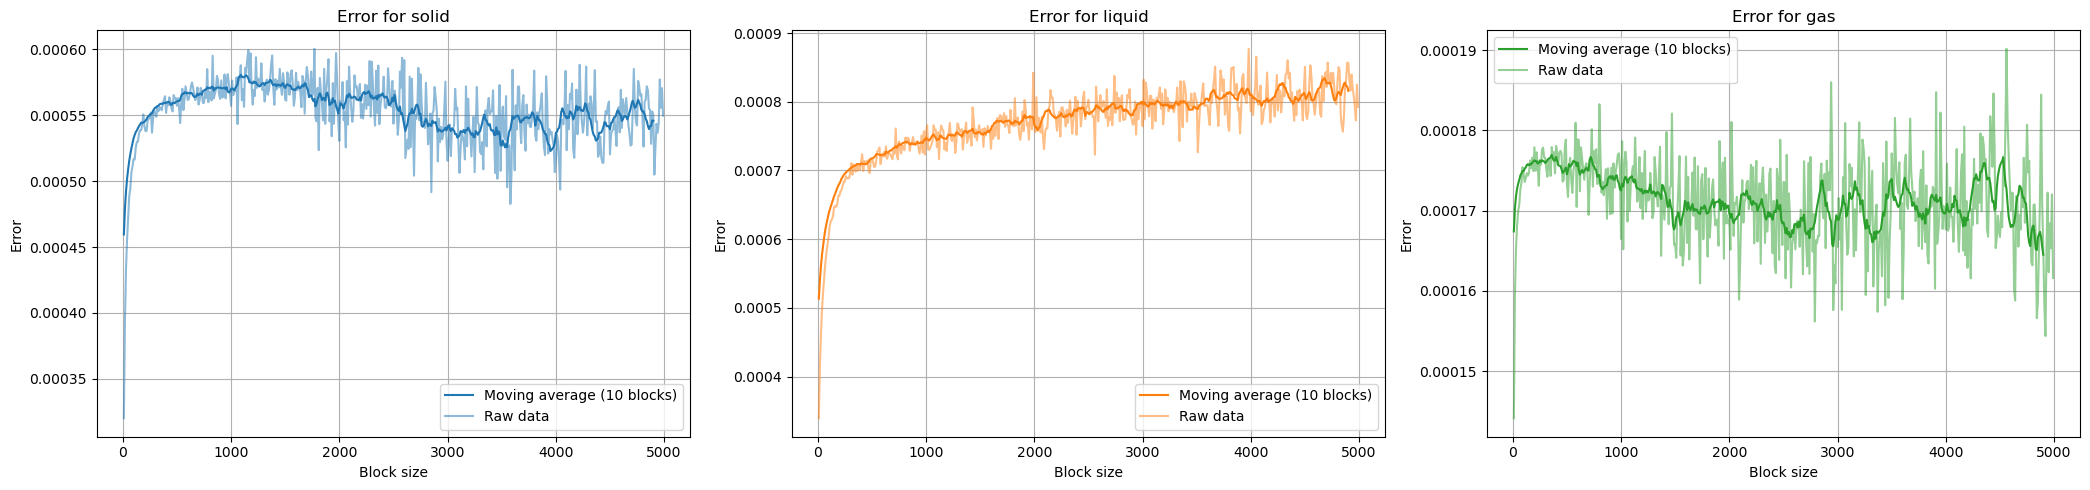

In [9]:

fig = plt.figure(figsize=(21,5))
errors_ = []
for i in range(3):
    fig.add_subplot(1,3,i+1)
    # moving average
    errors_.append(np.convolve(errors[i], np.ones(10)/10, mode='valid'))
    plt.plot(blck_len[:len(errors_[i])], errors_[i], color=colors[i], label = "Moving average (10 blocks)")
    plt.plot(blck_len, errors[i], color=colors[i], alpha=0.5, label="Raw data")
    plt.title("Error for {phase}".format(phase=names[i]))
    plt.xlabel("Block size")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

In [10]:
rootdir = "../data/ex07/OUTPUT_{sim}_{phase}/{quantity}.dat"

pot_solid_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="SOLID", quantity="potential_energy"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pot_liquid_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="LIQUID", quantity="potential_energy"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pot_gas_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="GAS", quantity="potential_energy"), unpack=True, skiprows=1, usecols = (0, 2, 3))

pot_solid_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="SOLID", quantity="potential_energy"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pot_liquid_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="LIQUID", quantity="potential_energy"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pot_gas_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="GAS", quantity="potential_energy"), unpack=True, skiprows=1, usecols = (0, 2, 3))

pressure_solid_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="SOLID", quantity="pressure"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pressure_liquid_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="LIQUID", quantity="pressure"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pressure_gas_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="GAS", quantity="pressure"), unpack=True, skiprows=1, usecols = (0, 2, 3))

pressure_solid_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="SOLID", quantity="pressure"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pressure_liquid_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="LIQUID", quantity="pressure"), unpack=True, skiprows=1, usecols = (0, 2, 3))
pressure_gas_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="GAS", quantity="pressure"), unpack=True, skiprows=1, usecols = (0, 2, 3))

gofr_solid_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="SOLID", quantity="gofr"), unpack=True, skiprows=1, usecols=(1, 2, 3))
gofr_liquid_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="LIQUID", quantity="gofr"), unpack=True, skiprows=1, usecols=(1, 2, 3))
gofr_gas_NVE = np.loadtxt(rootdir.format(sim="NVE", phase="GAS", quantity="gofr"), unpack=True, skiprows=1, usecols=(1, 2, 3))

gofr_solid_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="SOLID", quantity="gofr"), unpack=True, skiprows=1, usecols=(1, 2, 3))
gofr_liquid_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="LIQUID", quantity="gofr"), unpack=True, skiprows=1, usecols=(1, 2, 3))
gofr_gas_NVT = np.loadtxt(rootdir.format(sim="NVT", phase="GAS", quantity="gofr"), unpack=True, skiprows=1, usecols=(1, 2, 3))





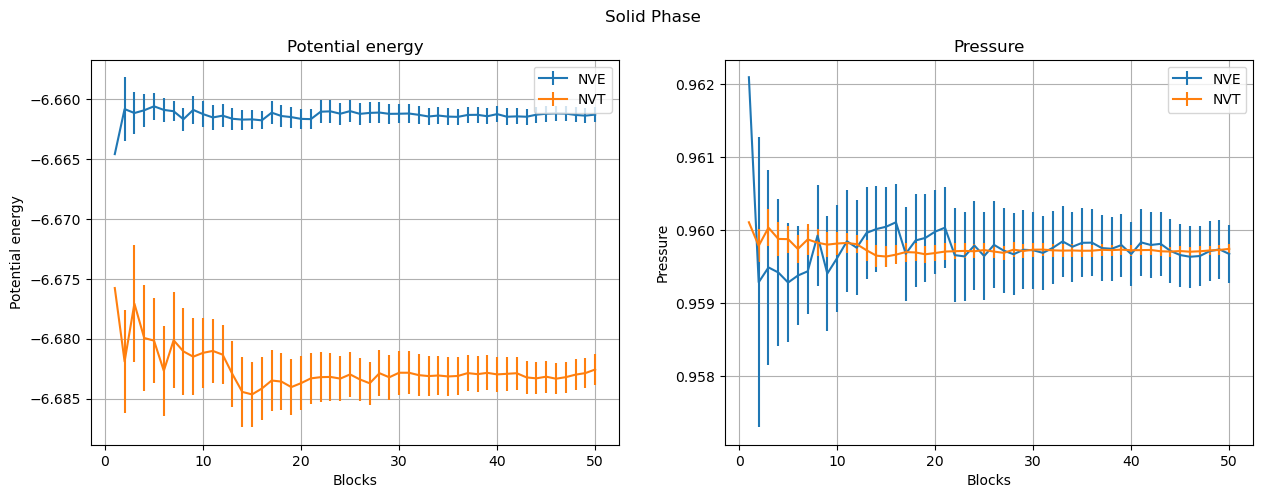

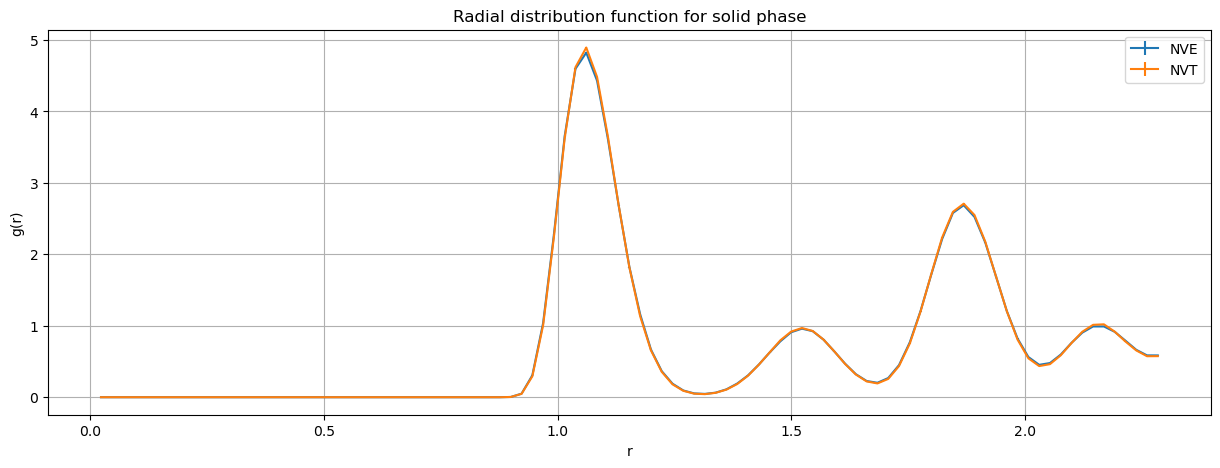

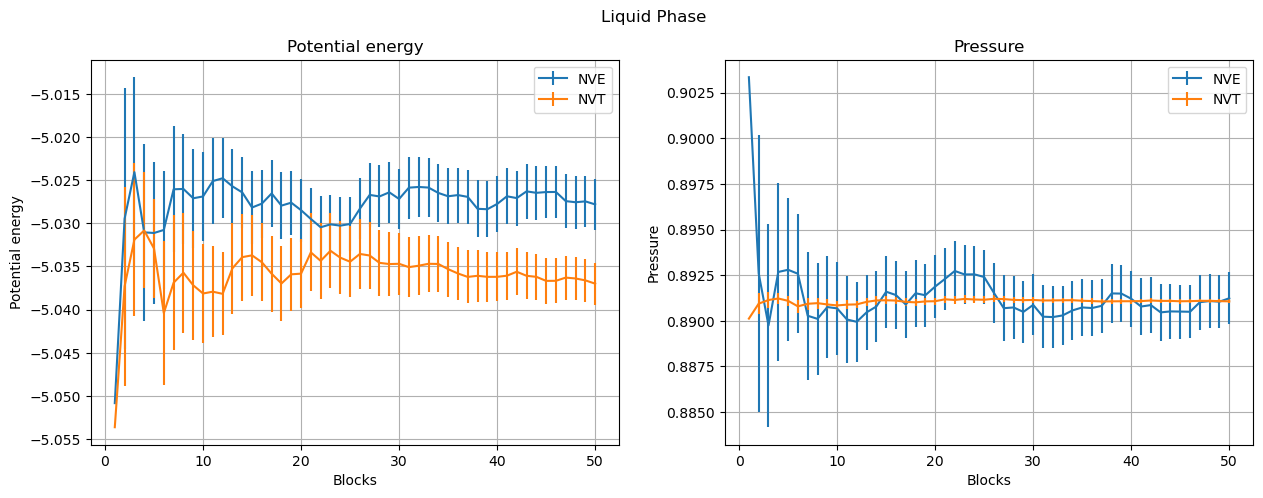

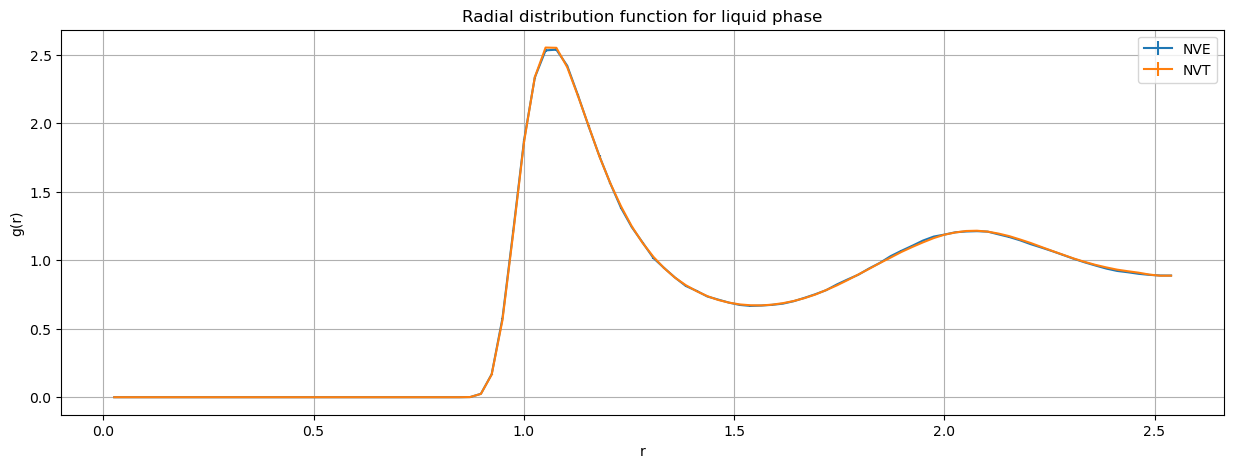

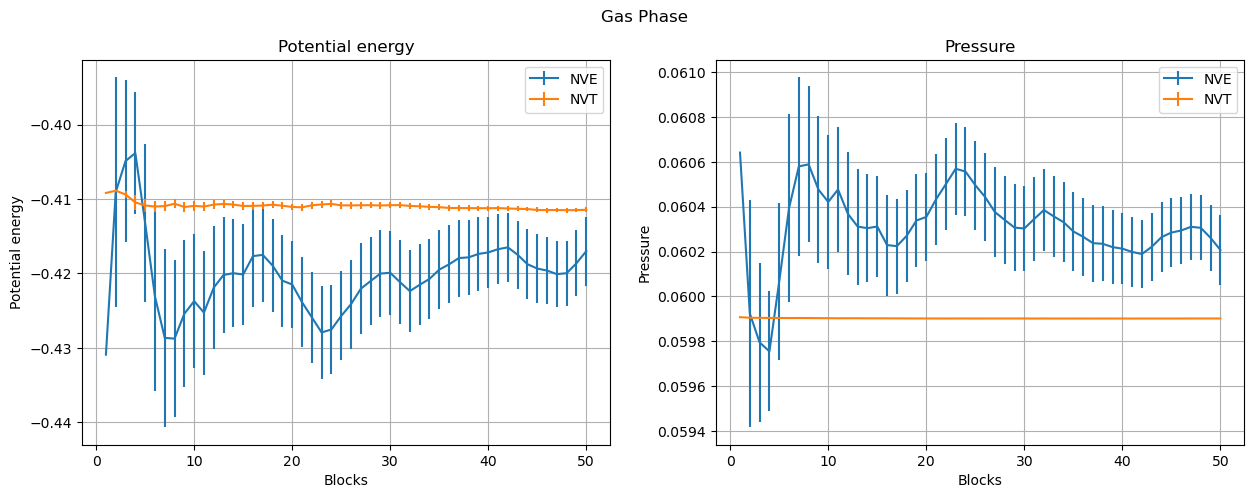

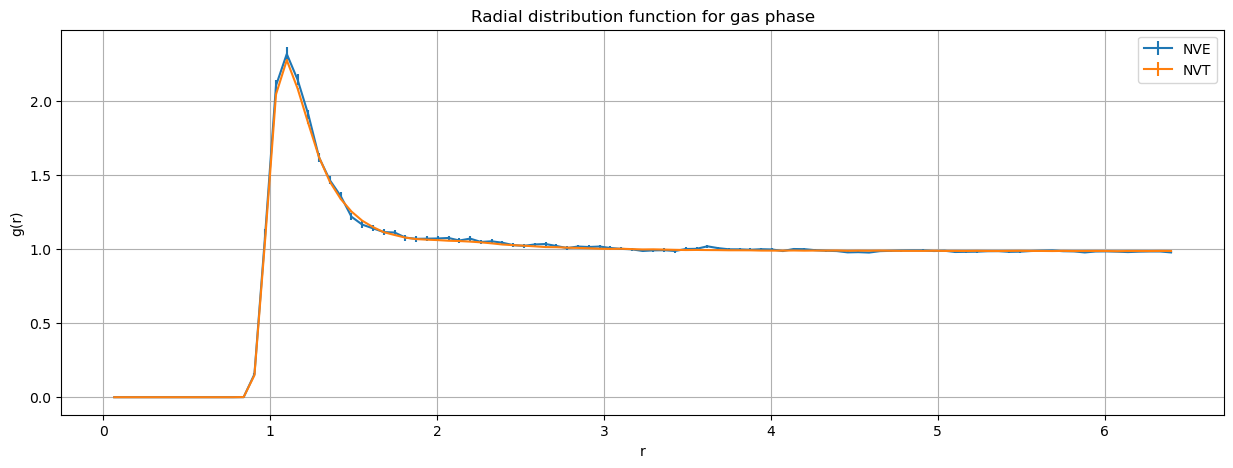

In [11]:
# Solid phase
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Solid Phase')

axs[0].errorbar(pot_solid_NVE[0], pot_solid_NVE[1], yerr=pot_solid_NVE[2], label="NVE", color=colors[0])
axs[0].errorbar(pot_solid_NVT[0], pot_solid_NVT[1], yerr=pot_solid_NVT[2], label="NVT", color=colors[1])
axs[0].set_title("Potential energy")
axs[0].set_xlabel("Blocks")
axs[0].set_ylabel("Potential energy")
axs[0].grid(True)
axs[0].legend()

axs[1].errorbar(pressure_solid_NVE[0], pressure_solid_NVE[1], yerr=pressure_solid_NVE[2], label="NVE", color=colors[0])
axs[1].errorbar(pressure_solid_NVT[0], pressure_solid_NVT[1], yerr=pressure_solid_NVT[2], label="NVT", color=colors[1])
axs[1].set_title("Pressure")
axs[1].set_xlabel("Blocks")
axs[1].set_ylabel("Pressure")
axs[1].grid(True)
axs[1].legend()

plt.show()

fig = plt.figure(figsize=(15,5))

plt.errorbar(gofr_solid_NVE[0], gofr_solid_NVE[1], yerr=gofr_solid_NVE[2], label="NVE", color=colors[0])
plt.errorbar(gofr_solid_NVT[0], gofr_solid_NVT[1], yerr=gofr_solid_NVT[2], label="NVT", color=colors[1])
plt.title("Radial distribution function for solid phase")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.grid(True)
plt.legend()
plt.show()


# Liquid phase
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Liquid Phase')

axs[0].errorbar(pot_liquid_NVE[0], pot_liquid_NVE[1], yerr=pot_liquid_NVE[2], label="NVE", color=colors[0])
axs[0].errorbar(pot_liquid_NVT[0], pot_liquid_NVT[1], yerr=pot_liquid_NVT[2], label="NVT", color=colors[1])
axs[0].set_title("Potential energy")
axs[0].set_xlabel("Blocks")
axs[0].set_ylabel("Potential energy")
axs[0].grid(True)
axs[0].legend()

axs[1].errorbar(pressure_liquid_NVE[0], pressure_liquid_NVE[1], yerr=pressure_liquid_NVE[2], label="NVE", color=colors[0])
axs[1].errorbar(pressure_liquid_NVT[0], pressure_liquid_NVT[1], yerr=pressure_liquid_NVT[2], label="NVT", color=colors[1])
axs[1].set_title("Pressure")
axs[1].set_xlabel("Blocks")
axs[1].set_ylabel("Pressure")
axs[1].grid(True)
axs[1].legend()

plt.show()

fig = plt.figure(figsize=(15,5))

plt.errorbar(gofr_liquid_NVE[0], gofr_liquid_NVE[1], yerr=gofr_liquid_NVE[2], label="NVE", color=colors[0])
plt.errorbar(gofr_liquid_NVT[0], gofr_liquid_NVT[1], yerr=gofr_liquid_NVT[2], label="NVT", color=colors[1])
plt.title("Radial distribution function for liquid phase")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.grid(True)
plt.legend()
plt.show()

# Gas phase
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Gas Phase')

axs[0].errorbar(pot_gas_NVE[0], pot_gas_NVE[1], yerr=pot_gas_NVE[2], label="NVE", color=colors[0])
axs[0].errorbar(pot_gas_NVT[0], pot_gas_NVT[1], yerr=pot_gas_NVT[2], label="NVT", color=colors[1])
axs[0].set_title("Potential energy")
axs[0].set_xlabel("Blocks")
axs[0].set_ylabel("Potential energy")
axs[0].grid(True)
axs[0].legend()

axs[1].errorbar(pressure_gas_NVE[0], pressure_gas_NVE[1], yerr=pressure_gas_NVE[2], label="NVE", color=colors[0])
axs[1].errorbar(pressure_gas_NVT[0], pressure_gas_NVT[1], yerr=pressure_gas_NVT[2], label="NVT", color=colors[1])
axs[1].set_title("Pressure")
axs[1].set_xlabel("Blocks")
axs[1].set_ylabel("Pressure")
axs[1].grid(True)
axs[1].legend()

plt.show()

fig = plt.figure(figsize=(15,5))

plt.errorbar(gofr_gas_NVE[0], gofr_gas_NVE[1], yerr=gofr_gas_NVE[2], label="NVE", color=colors[0])
plt.errorbar(gofr_gas_NVT[0], gofr_gas_NVT[1], yerr=gofr_gas_NVT[2], label="NVT", color=colors[1])
plt.title("Radial distribution function for gas phase")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.grid(True)
plt.legend()
plt.show()


## Some observations
It is nice to see that pressure behaviour changes from NVE to NVT. In NVT, as the temperature and volume are fixed, and by interpreting the pressure as a measure of the kinetic energy, we expect it to be costant.
In NVE, temperature is not fixed, so the pressure is not constant.



<!--


 -->